In [ ]:
%matplotlib notebook
%cd ..

# Stochastic Models (smps files)

Utilities contained in this repo can be used to parse stochastic models stored in files in the SMPS format [1].

Basic use:

In [2]:
from smps.smps_read import StochasticModel
BENCHMARKS_PATH = 'smps/benchmark_problems'

sm = StochasticModel(BENCHMARKS_PATH+'/2_sizes/sizes10')

Parsing nominal model information from smps/benchmark_problems/2_sizes/sizes10.cor and .tim ...
Parsing stochastic information from smps/benchmark_problems/2_sizes/sizes10.sto ...
Stochastic model is of type SCENARIOS DISCRETE


The `sm` instance contains all the information about the stochastic model stored in the files `sizes10.cor`, `sizes10.tim`, `sizes10.sto` in SMPS format. All the data about the nominal model can be easily accessed as follows:

![Nominal Model Structure](img/stoch_model_struct.png)
Image source [2]

In [3]:
print(sm.c[2])
# print(sm.A[2,2])  # long..
print(sm.b[2])
print(sm.lb[1])

[ 453.   453.   453.   453.   453.   453.   453.   453.   453.   453.   748.
  758.4  768.8  779.2  789.6  800.   810.4  820.8  831.2  841.6    0.     0.
    8.     0.     8.     8.     0.     8.     8.     8.     0.     8.     8.
    8.     8.     0.     8.     8.     8.     8.     8.     0.     8.     8.
    8.     8.     8.     8.     0.     8.     8.     8.     8.     8.     8.
    8.     0.     8.     8.     8.     8.     8.     8.     8.     8.     0.
    8.     8.     8.     8.     8.     8.     8.     8.     8. ]
[   2.5    7.5   12.5   10.    35.    25.    15.    12.5   12.5    5.     0.
    0.     0.     0.     0.     0.     0.     0.     0.     0.     0.     0.
    0.     0.     0.     0.     0.     0.     0.     0.   200. ]
[ 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.
  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.
  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.
  0.  0.  0.  0.  0.  0.  0.  0.  0

### Plotting Scenario Trees
We can produce a graph of the decision process tree as follows:

Parsing nominal model information from smps/benchmark_problems/posts/2_sg/sgpf5y3.cor and .tim ...
Parsing stochastic information from smps/benchmark_problems/posts/2_sg/sgpf5y3.sto ...
Stochastic model is of type SCENARIOS DISCRETE


<IPython.core.display.Javascript object>


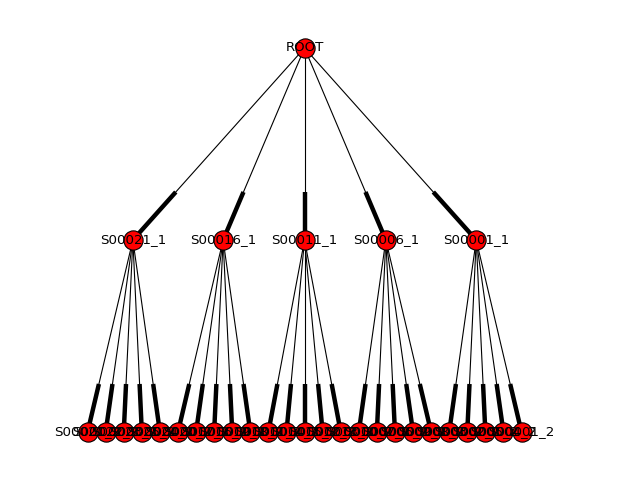

In [4]:
# requires GraphViz [3] to be installed
# plot the tree of a problem with 3 stages
sm_3stage = StochasticModel(BENCHMARKS_PATH+'/posts/2_sg/sgpf5y3')
sm_3stage.plot_scenario_tree()

### Deterministic Equivalent 
We can construct and solve (requires Gurobi) the deterministic equivalent as follows:

In [ ]:
gb_opt_model = sm.generate_deterministic_equivalent()
gb_opt_model.params.MIPGap = 0.01
gb_opt_model.optimize()

### Decomposition of computations

We use duality in this context to divide the problem in a set of individual optimizations, one for each scenario. The code includes all is necessary to produce an appropriate oracle.

In [5]:
from smps.oracles import TwoStage_SMPS_InnerProblem

ip = TwoStage_SMPS_InnerProblem(BENCHMARKS_PATH+'/2_sslp/sslp_5_25_3_mymod')

Parsing nominal model information from smps/benchmark_problems/2_sslp/sslp_5_25_3_mymod.cor and .tim ...
Parsing stochastic information from smps/benchmark_problems/2_sslp/sslp_5_25_3_mymod.sto ...
Stochastic model is of type SCENARIOS DISCRETE


In [6]:
# These constitute the first order oracle we need in the decomposition framework.
print(ip.oracle)
print(ip.projection_function)

<bound method TwoStage_SMPS_InnerProblem.oracle of <smps.oracles.TwoStage_SMPS_InnerProblem object at 0x0000000019AAC940>>
<bound method TwoStage_SMPS_InnerProblem.projection_function of <smps.oracles.TwoStage_SMPS_InnerProblem object at 0x0000000019AAC940>>


In [7]:
from nsopy import UniversalPGM as UPGM
from nsopy import UniversalDGM as UDGM
from nsopy import UniversalFGM as UFGM
from nsopy import SlimDualMethodLogger, DualDgmFgmMethodLogger

In [9]:
method_avg = UPGM(ip.oracle, ip.projection_function, dimension=ip.dimension, epsilon=1.0, averaging=True)
logger_avg = DualDgmFgmMethodLogger(method_avg)

method_nonavg = UPGM(ip.oracle, ip.projection_function, dimension=ip.dimension, epsilon=1.0, averaging=False)
logger_nonavg = DualDgmFgmMethodLogger(method_nonavg)

In [13]:
for gg in range(30):
    if not gg%10:
        print gg
    method_avg.dual_step()
    method_nonavg.dual_step()

0
10
20


In [14]:
import matplotlib.pyplot as plt
%matplotlib notebook

<IPython.core.display.Javascript object>


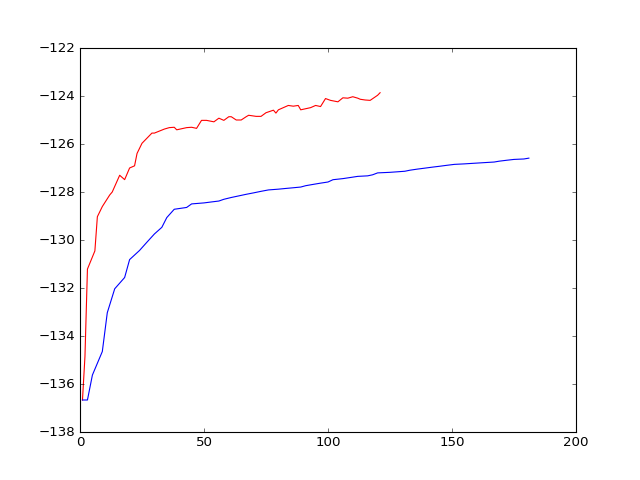

In [15]:
plt.plot(logger_nonavg.oracle_calls, logger_nonavg.d_k_iterates, 'r')
plt.plot(logger_avg.oracle_calls, logger_avg.d_k_iterates, 'b')

In [ ]:
plt.figure()
plt.plot(logger_avg.L_k_iterates, 'b')
plt.plot(logger_nonavg.L_k_iterates, 'r')

The following notebooks show how to use the oracle.

### References
* [1] H.I. Gassmann, The SMPS file format, http://myweb.dal.ca/gassmann/smps2.htm, 2005
* [2] http://www.maximalsoftware.com/resources/GassmannKristjansson_dpm007v1.pdf
* [3] GraphViz, available at: http://www.graphviz.org/Download..php